# Assignment 5

Deadline: 11.06.2025 12:00 CEST

## Task

Develop an investment strategy for the Swiss equity market, backtest it using the provided datasets (`market_data.parquet`, `jkp_data.parquet`, `spi_index.csv`) and analyze its performance by benchmarking it against the SPI index. Work with the existing code infrastructure (`qpmwp-course`) and extend it by implementing any additional components needed for the strategy. Write a report that presents your methodology and the results.

### Coding (15 points)

- Selection:
  Implement selection item builder functions (via `SelectionItemBuilder`) to filter stocks based on specific criteria (e.g., exclude low-quality or high-volatility stocks).

- Optimization Data & Constraints:
  Implement functions to prepare optimization data (via `OptimizationItemBuilder`), including any econometric or machine learning-based predictions. These functions should also define optimization constraints (e.g., stock, sector, or factor exposure limits).

- Optimization Model:
  If you choose to create a custom optimization model, develop a class inheriting from Optimization (similar to `MeanVariance`, `LeastSquares`, or `BlackLitterman`). Your class should include methods set_objective and solve for defining the objective function and solving the optimization problem.

- Machine Learning Prediction:
  Integrate a machine learning model to estimate inputs for the optimization, such as expected returns or risk. This could include regression, classification, or learning-to-rank models. I suggest you to use the provided jkp_data as features, but you may also create your own (e.g., technical indicators computed on the return or price series).

- Simulation:
  Backtest the strategy and simulate portfolio returns. Account for fixed costs (1% per annum) and variable (transaction) costs (0.2% per rebalancing).


### Report (15 points):

Generate an HTML report with the following sections:

- High-level strategy overview: Describe the investment strategy you developed.

- Detailed explanation of the backtesting steps: Offer a more comprehensive breakdown of the backtesting process, including a description of the models implemented (e.g., details of the machine learning method used).

- Backtesting results:
    
    - Charts: Include visual representations (e.g., cumulative performance charts, rolling 3-year returns, etc.).
    - Descriptive statistics: Present key statistics such as mean, standard deviation, drawdown, turnover, and Sharpe ratio (or any other relevant metric) for the full backtest period as well as for subperiods (e.g., the last 5 years, or during bull vs. bear market phases).
    - Compare your strategy against the SPI index.


In [ ]:
# Standard library imports
import os
import sys

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()
src_path = os.getenv('PROJECT_SOURCE_DIR')
#print(src_path)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance

from optimization.optimization import (
    BlackLitterman,                                 
)
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    # Selection item builder functions
    bibfn_selection_min_volume,
    bibfn_selection_NA,
    bibfn_selection_gaps,
    bibfn_selection_jkp_factor_scores,
    bibfn_selection_ltr,

    # Optimization item builder functions
    bibfn_return_series,
    bibfn_bm_series,
    bibfn_cap_weights, 
    bibfn_size_dependent_upper_bounds,
    bibfn_turnover_constraint,  
    bibfn_scores_ltr,      
                            
    # Constraints item builder functions
    bibfn_budget_constraint,
    bibfn_box_constraints,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest


In [ ]:
# --------------------------------------------------------------------------
# Load data
# - market data (from parquet file)
# - jkp data (from parquet file)
# - swiss performance index, SPI (from csv file)
# --------------------------------------------------------------------------

path_to_data = '../data/'

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')
jkp_data = pd.read_parquet(path = f'{path_to_data}jkp_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.jkp_data = jkp_data
data.bm_series = load_data_spi(path='../data/')


In [25]:

# --------------------------------------------------------------------------
# Create a features dataframe from the jkp_data
# Reset the date index to be consistent with the date index in market_data
# --------------------------------------------------------------------------

market_data_dates = data.market_data.index.get_level_values('date').unique().sort_values()
jkp_data_dates = data.jkp_data.index.get_level_values('date').unique().sort_values()

# Find the nearest future market_data_date for each jkp_data_date
dates_map = {
    date: min(market_data_dates[market_data_dates > date])
    for date in jkp_data_dates
}

# Generates a features dataframe from the jkp_data where you reset
# the date index to b
features = data.jkp_data.reset_index()
features['date'] = features['date'].map(dates_map)
features = features.set_index(['date', 'id'])


In [26]:
# --------------------------------------------------------------------------
# Define training dates and rebalancing dates
# --------------------------------------------------------------------------

train_dates = features.index.get_level_values('date').unique().sort_values()
train_dates = train_dates[train_dates > market_data_dates[0]]
rebdates = train_dates[train_dates >= '2015-01-01'].strftime('%Y-%m-%d').tolist()
rebdates = rebdates[0:-1]
rebdates

['2015-01-01',
 '2015-02-02',
 '2015-03-02',
 '2015-04-01',
 '2015-05-01',
 '2015-06-01',
 '2015-07-01',
 '2015-08-03',
 '2015-09-01',
 '2015-10-01',
 '2015-11-02',
 '2015-12-01',
 '2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-02',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-03',
 '2016-11-01',
 '2016-12-01',
 '2017-01-02',
 '2017-02-01',
 '2017-03-01',
 '2017-04-03',
 '2017-05-01',
 '2017-06-01',
 '2017-07-03',
 '2017-08-01',
 '2017-09-01',
 '2017-10-02',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-02',
 '2018-05-01',
 '2018-06-01',
 '2018-07-02',
 '2018-08-01',
 '2018-09-03',
 '2018-10-01',
 '2018-11-01',
 '2018-12-03',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-03',
 '2019-07-01',
 '2019-08-01',
 '2019-09-02',
 '2019-10-01',
 '2019-11-01',
 '2019-12-02',
 '2020-01-01',
 '2020-02-03',
 '2020-03-02',
 '2020-04-01',
 '2020-05-01',
 '2020-06-01',
 '2020-07-

In [27]:
# --------------------------------------------------------------------------
# Prepare labels (i.e., ranks of period returns)
# --------------------------------------------------------------------------

# Load return series
return_series = data.get_return_series()

# Compute period returns between the training dates
return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change(fill_method=None)

# Shift the labels by -1 period (as we want to predict next period return ranks)
return_series_agg_shift = return_series_agg.shift(-1)
# return_series_agg_shift = return_series_agg   # ~~~~~~~~~~~~~~~~~~~~~~~~

# Stack the returns (from wide to long format)
ret = return_series_agg_shift.unstack().reorder_levels([1, 0]).dropna()
ret.name = 'ret'
ret

# Merge the returns and the features dataframes
merged_df = ret.to_frame().join(features, how='inner').sort_index()
merged_df

# Generate the labels (ranks) for the merged data
labels = merged_df.groupby('date')['ret'].rank(method='first', ascending=True).astype(int)
labels = 100 * labels / merged_df.groupby('date').size() # Normalize the ranks to be between 0 and 100
labels = labels.astype(int)  # Convert to integer type
labels

# Insert the labels into the merged data frame
merged_df.insert(0, 'label', labels)
merged_df

# Reset the index of the merged data frame
merged_df.reset_index(inplace=True)
merged_df

# Add the merged data frame to the BacktestData object
data.merged_df = merged_df


In [28]:

# --------------------------------------------------------------------------
# Prepare backtest service
# --------------------------------------------------------------------------

JKP_FIELDS = ['qmj', 'ret_12_1', 'resff3_6_1']

selection_item_builders = {
    # 1. Liquidity filter
    'min_volume': SelectionItemBuilder(
        bibfn=bibfn_selection_min_volume,
        width=252,
        min_volume=100_000,
        agg_fn=np.median,
    ),
    # 2. Data quality filter
    'NA_check': SelectionItemBuilder(
        bibfn=bibfn_selection_NA,
        width=252,
        na_threshold=10,
    ),
    # 3. Trading continuity filter
    'gaps': SelectionItemBuilder(
        bibfn=bibfn_selection_gaps,
        width=252*3,
        n_days=10,
    ),
    # 4. Factor-based filter (optional, e.g. quality/momentum/size)
    'scores': SelectionItemBuilder(
        bibfn=bibfn_selection_jkp_factor_scores,
        fields=JKP_FIELDS,
    ),
    # 5. Learning-to-rank ML filter (optional, for ML-based selection)
    'ltr': SelectionItemBuilder(
        bibfn=bibfn_selection_ltr,
    ),
}

optimization_item_builders = {
    # 1. Return series for risk estimation
    'return_series': OptimizationItemBuilder(
        bibfn=bibfn_return_series,
        width=252*3,
    ),
    # 2. Benchmark series (SPI)
    'bm_series': OptimizationItemBuilder(
        bibfn=bibfn_bm_series,
        width=252*3,
        align=True,
        name='bm_series',
    ),
    # 3. Budget constraint (fully invested)
    'budget_constraint': OptimizationItemBuilder(
        bibfn=bibfn_budget_constraint,
        budget=1,
    ),
    # 4. Box constraints (long-only, max 20% per stock)
    'box_constraints': OptimizationItemBuilder(
        bibfn=bibfn_box_constraints,
        lower=0.0,
        upper=0.2,
        box_type='LongOnly',
    ),
    # 5. Size-dependent upper bounds (optional, for diversification)
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn=bibfn_size_dependent_upper_bounds,
        small_cap={'threshold': 300_000_000, 'upper': 0.02},
        mid_cap={'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap={'threshold': 10_000_000_000, 'upper': 0.1},
    ),
    # 6. Cap-weighted benchmark weights (optional)
    'cap_weights': OptimizationItemBuilder(
        bibfn=bibfn_cap_weights,
    ),
    # 7. Turnover constraint (optional, to control trading costs)
    'turnover_constraint': OptimizationItemBuilder(
        bibfn=bibfn_turnover_constraint,
        turnover_limit=0.2,
    ),
    # 8. ML-based scores for Black-Litterman views
    'scores_ltr': OptimizationItemBuilder(
        bibfn=bibfn_scores_ltr,
        params_xgb={
            'objective': 'rank:pairwise',
            'min_child_weight': 1,
            'max_depth': 6,
            'eta': 0.1,
            'gamma': 1.0,
            'lambda': 1,
            'alpha': 0,
        },
        training_dates=train_dates,
    ),

}

optimization =BlackLitterman(
        solver_name='cvxopt',
        covariance=Covariance(method='pearson'),
        risk_aversion=1,
        tau_psi=0.01,
        tau_omega=0.0001,
        # view_method='quintile',
        view_method='absolute',
        fields=['scores'],
)

# Initialize the backtest service
bs = BacktestService(
    data = data,
    optimization=optimization,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

In [29]:
# --------------------------------------------------------------------------
# Run backtests
# --------------------------------------------------------------------------

bt_bl_ltr = Backtest()
bt_bl_ltr.run(bs=bs)

# --------------------------------------------------------------------------
# Save the backtest results 
# --------------------------------------------------------------------------

bt_bl_ltr.save(
    path='../data/',
    filename='backtest_bl_ltr.pickle'
)


Rebalancing date: 2015-01-01
Rebalancing date: 2015-02-02
Rebalancing date: 2015-03-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-05-01
Rebalancing date: 2015-06-01
Rebalancing date: 2015-07-01
Rebalancing date: 2015-08-03
Rebalancing date: 2015-09-01
Rebalancing date: 2015-10-01
Rebalancing date: 2015-11-02
Rebalancing date: 2015-12-01
Rebalancing date: 2016-01-01
Rebalancing date: 2016-02-01
Rebalancing date: 2016-03-01
Rebalancing date: 2016-04-01
Rebalancing date: 2016-05-02
Rebalancing date: 2016-06-01
Rebalancing date: 2016-07-01
Rebalancing date: 2016-08-01
Rebalancing date: 2016-09-01
Rebalancing date: 2016-10-03
Rebalancing date: 2016-11-01
Rebalancing date: 2016-12-01
Rebalancing date: 2017-01-02
Rebalancing date: 2017-02-01
Rebalancing date: 2017-03-01
Rebalancing date: 2017-04-03
Rebalancing date: 2017-05-01
Rebalancing date: 2017-06-01
Rebalancing date: 2017-07-03
Rebalancing date: 2017-08-01
Rebalancing date: 2017-09-01
Rebalancing date: 2017-10-02
Rebalancing da

C:\Users\mwk-a\Documents\UZH\QPM\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
C:\Users\mwk-a\Documents\UZH\QPM\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Cumulative Performance'}>

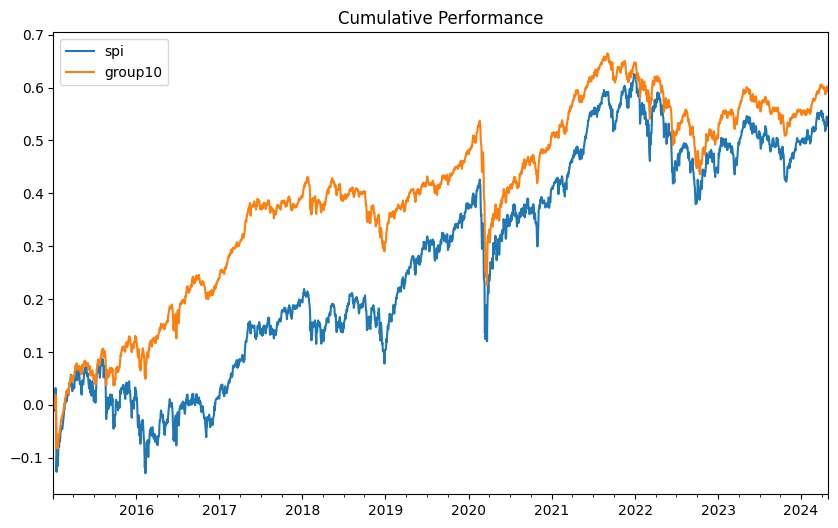

In [30]:
# --------------------------------------------------------------------------
# Simulate strategy
# --------------------------------------------------------------------------

bt_bl_ltr = load_pickle(
    filename='backtest_bl_ltr.pickle',
    path='../data/',
)

fixed_costs = 0.01  # 1% per annum
variable_costs = 0.002  # 0.2% per rebalancing
return_series = bs.data.get_return_series()

# Simulate net returns (including costs)
sim_net = bt_bl_ltr.strategy.simulate(
    return_series=return_series,
    fc=fixed_costs,
    vc=variable_costs,
)

# Combine with benchmark for comparison
sim = pd.concat({
    'spi': bs.data.bm_series,
    'group10': sim_net,
}, axis=1).dropna()

# Plot cumulative performance
np.log1p(sim).cumsum().plot(title='Cumulative Performance', figsize=(10, 6))

Annualized turnover: 1.4341163487503006


2015-01-01    1.000000
2015-02-02    0.200000
2015-03-02    0.140357
2015-04-01    0.131239
2015-05-01    0.108142
                ...   
2023-11-01    0.133834
2023-12-01    0.108180
2024-01-01    0.104697
2024-02-01    0.100664
2024-03-01    0.099815
Length: 111, dtype: float64

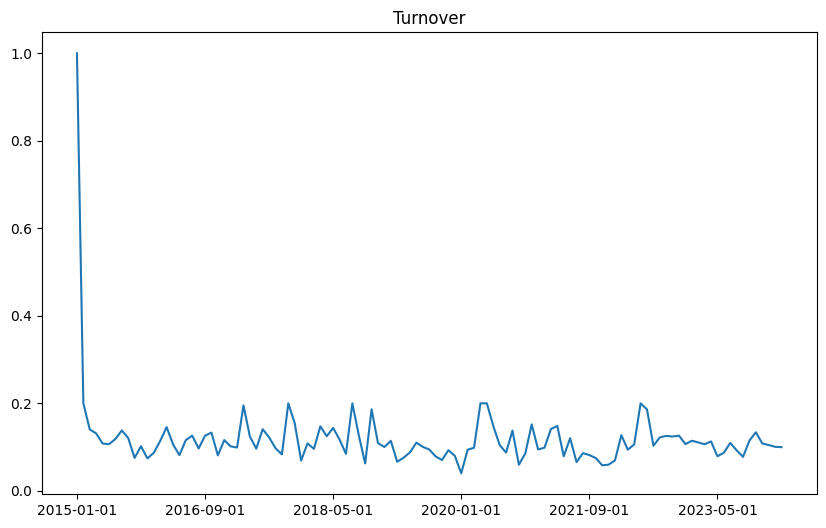

In [31]:
# --------------------------------------------------------------------------
# Turnover
# --------------------------------------------------------------------------

to_bl_ltr = bt_bl_ltr.strategy.turnover(return_series=return_series)

to_bl_ltr.plot(title='Turnover', figsize=(10, 6))
print("Annualized turnover:", to_bl_ltr.mean() * 12)
to_bl_ltr

In [35]:
# --------------------------------------------------------------------------
# Decriptive statistics
# --------------------------------------------------------------------------

import empyrical as ep

# Compute individual performance metrics for each simulated strategy using empyrical
annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    #print(f'Performance metrics for {column}')
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['spi'])


annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd])

,spi,group10
Annual Return,0.056569,0.064027
Cumulative Return,0.701100,0.820623
Annual Volatility,0.145660,0.100794
Sharpe Ratio,0.451055,0.666456
Max Drawdown,-0.263289,-0.267342


Suggestions for Improvement

1. Factor Enhancements
- Expand Factor Set: Currently, you use qmj, ret_12_1, and resff3_6_1. Consider adding:
    - Value (e.g., book-to-market, earnings yield)
    - Low Volatility (e.g., past 12M volatility)
    - Size (market cap)
    - Dividend Yield
    - Quality (profitability, leverage, earnings stability)
    - Growth (sales/earnings growth)
- Nonlinear Factor Combinations: Use interaction terms or polynomial features to capture nonlinearities.

2. Machine Learning Improvements
- Feature Engineering:
    - Add technical indicators (momentum, RSI, moving averages).
    - Use rolling window statistics (mean, std, skewness, kurtosis).
    - Include macroeconomic variables if available (interest rates, FX, etc.).
- Modeling:
    - Try other ML models (LightGBM, CatBoost, neural nets).
    - Use ensemble methods (combine several models).
    - Calibrate hyperparameters with cross-validation.
- Target Engineering:
    - Instead of only ranking next-period returns, try predicting probability of outperformance or expected drawdown.
    - Use classification (up/down) or regression (expected return) as alternative targets.

3. Bear Market Preparation (Long-Only)
- Dynamic Risk Control:
    - Volatility Targeting: Reduce portfolio exposure when market volatility spikes.
    - Drawdown Control: Implement rules to reduce risk after large drawdowns.
- Defensive Factor Tilt:
    - Increase weights on defensive factors (low volatility, quality, dividend yield) when market signals are negative.
- Market Regime Detection:
    - Use regime-switching models or ML classifiers to detect bear markets and adjust factor exposures accordingly.
- Cash Buffer:
    - Allow a portion of the portfolio to be in cash (relax the fully-invested constraint) during high-risk periods.
- Sector Rotation:
    - Tilt towards defensive sectors (utilities, healthcare, consumer staples) in bear markets.